In [1]:
#Compute RMS of the errors in plot 3

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [3]:
# #Chicago
# LAT        = 41.8781
# LON        = 360-87.6298
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
########## CONUS ############
#CONUS lat-lon
top = 50.0 # north lat
left = -124.7844079+360 # west long
right = -66.9513812+360 # east long
bottom =  24.7433195 # south lat
################################
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Bengaluru/'
locn       = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
##############################
jul0_index = 181

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(5)

In [5]:
cluster

In [6]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [7]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 623 ms, sys: 123 ms, total: 746 ms
Wall time: 1.74 s


In [8]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw

CPU times: user 84.7 ms, sys: 923 µs, total: 85.6 ms
Wall time: 84.5 ms


,Array,Chunk
Bytes,225.56 GiB,769.92 MiB
Shape,"(10950, 192, 288, 100)","(3650, 192, 288, 1)"
Count,2001 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [9]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 669 ms, sys: 11.6 ms, total: 681 ms
Wall time: 673 ms


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,57502 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [10]:
#tgmw_DJF = tgmw.sel(tgmw.time.dt.season=='DJF')
tgmw_djf  = tgmw.sel(time=tgmw.time.dt.month.isin([12,1,2]))
# tgmw_jul  = tgmw.sel(time=tgmw.time.dt.month.isin([7]))
# tgmw_jan  = tgmw.sel(time=tgmw.time.dt.month.isin([1]))
# tgmw_feb  = tgmw.sel(time=tgmw.time.dt.month.isin([2]))
# tgmw_dec  = tgmw.sel(time=tgmw.time.dt.month.isin([12]))
#######################################
# tgmw_mam  = tgmw.sel(time=tgmw.time.dt.month.isin([3,4,5]))
# tgmw_jja  = tgmw.sel(time=tgmw.time.dt.month.isin([6,7,8]))
# tgmw_son  = tgmw.sel(time=tgmw.time.dt.month.isin([9,10,11]))
tgmw_djf

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


,Array,Chunk
Bytes,111.24 GiB,61.80 MiB
Shape,"(5400, 192, 288, 100)","(270, 20, 30, 100)"
Count,60002 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [11]:
# %%time
# #Save files
# djf_path = cvals+'tgmw_djf'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# tgmw_djf.to_dataset().to_zarr(djf_path)

In [12]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [13]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [14]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [15]:
%%time
# tgmw_djfgroup = tgmw_djf.groupby('time.dayofyear').apply(stacker)
# len(tgmw_djf.groupby('time.dayofyear').groups[1])
tgmw_ddjf = to_daily(tgmw_djf)
# tgmw_ddec = to_daily(tgmw_dec)
# tgmw_djan = to_daily(tgmw_jan)
# tgmw_dfeb = to_daily(tgmw_feb)
tgmw_ddjf = tgmw_ddjf.chunk({'year':60,'day':5})
tgmw_ddjf

CPU times: user 206 ms, sys: 9.85 ms, total: 216 ms
Wall time: 213 ms


,Array,Chunk
Bytes,111.24 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 90)","(20, 30, 100, 60, 5)"
Count,87502 Tasks,1800 Chunks
Type,float32,numpy.ndarray


In [16]:
%%time
#Save files
ddjf_path = cvals+'tgmw_djf_daily'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# djul_path = cvals+'tgmw_djul_daily'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# ##### DJF ###########
#tgmw_ddjf.to_dataset().to_zarr(ddjf_path,mode='w')

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 8.82 µs


In [17]:
tgmw_ddjf = xr.open_zarr(ddjf_path)
tgmw_ddjf = tgmw_ddjf.TREFHTMX
tgmw_ddjf

,Array,Chunk
Bytes,111.24 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 90)","(20, 30, 100, 60, 5)"
Count,1801 Tasks,1800 Chunks
Type,float32,numpy.ndarray


In [18]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
#quants            = (0.1,0.01,0.5,0.9,0.99)
quants             = np.arange(0,1.01,0.01)
#tgmw_djulstack     = tgmw_djul.stack(ym=('year','member'),create_index=False)
#tgmw_julrndrop    = stack_roll_ndrop(tgmw_djul,N_mem*window_len,N_mem,15,251-14)
########################
N_mem              = 100
window_len         = 30
###### DJF #######
#r = roll, ndrop = drop NANs
tgmw_djfroll     = stack_roll(tgmw_ddjf,N_mem*window_len,N_mem)
#########
#tgmw_djulconstruct = tgmw_djulstack.rolling(ym=N_mem*window_len, center=True)\
##.construct('index', stride=N_mem)
tgmw_djfroll0   = tgmw_djfroll.sel(ym=[15,44])  
tgmw_djfroll0
###################

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 90, ym: 6000)>
dask.array<reshape, shape=(192, 288, 90, 6000), dtype=float32, chunksize=(20, 30, 5, 6000), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
    year     (ym) int64 1850 1850 1850 1850 1850 ... 2100 2100 2100 2100 2100
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
CPU times: user 285 ms, sys: 29.1 ms, total: 314 ms
Wall time: 307 ms


,Array,Chunk
Bytes,111.24 GiB,68.66 MiB
Shape,"(192, 288, 90, 2, 3000)","(20, 30, 5, 2, 3000)"
Count,195474 Tasks,1800 Chunks
Type,float32,numpy.ndarray


In [19]:
%%time
#Compute quantiles 
# qgmw_jul       = tgmw_julrndrop.quantile(quants,dim='index',skipna=False)
# qgmw_jul       = qgmw_djul.chunk({'ym':222})
#### DJF #######
qgmw_djf         = tgmw_djfroll0.quantile(quants,dim='index',skipna=False)
qgmw_djf         = qgmw_djf
qgmw_djf

CPU times: user 32.9 ms, sys: 879 µs, total: 33.8 ms
Wall time: 32.2 ms


,Array,Chunk
Bytes,7.49 GiB,4.62 MiB
Shape,"(101, 192, 288, 90, 2)","(101, 20, 30, 5, 2)"
Count,202674 Tasks,1800 Chunks
Type,float64,numpy.ndarray


In [20]:
# %%time
# qgmw_djf.sel(lat=LAT,lon=LON,method='nearest').sel(day=1,ym=0).values

In [21]:
%%time
#qgmw_julpath  = cvals+'qgmw_djul'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#### DJF ######
qgmw_djfpath  = cvals+'qgmw_djf'+'_'+pi_year0+'_'+ic_year1+'.zarr'
#qgmw_djf.to_dataset().to_zarr(qgmw_djfpath,mode='w')
### MAM #########


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 7.63 µs


In [22]:
%%time
qgmw_djf = xr.open_zarr(qgmw_djfpath)
qgmw_djf = qgmw_djf.TREFHTMX
qgmw_djf = qgmw_djf.assign_coords({'ym':[1865,2085]})
qgmw_djf

CPU times: user 10.9 ms, sys: 2.1 ms, total: 13 ms
Wall time: 29.9 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, day: 90, ym: 2)>
dask.array<open_dataset-607bd91f143d0d0d868db614de5f6b28TREFHTMX, shape=(101, 192, 288, 90, 2), dtype=float64, chunksize=(101, 20, 30, 5, 2), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 2085

In [23]:
#qmw=qgmw_djf.sel(lat=LAT,lon=LON,method='nearest')
qmw=qgmw_djf.sel(day=1)

In [24]:
######## Compute moment-adjusted series ##########

In [25]:
%%time
#Compute the pre-industrial + moments adjusted curve
#First compute rolling means and stdevs and save them
tgmw_djf_mroll = tgmw_djfroll0.mean(dim='index')
tgmw_djf_sroll = tgmw_djfroll0.std(dim='index')
##########
# tgmw_djf_mrollpath = cvals+'tgmw_djf_roll30yr_mean'+'_'+pi_year0+'_'+ic_year1+'.zarr'
# tgmw_djf_srollpath = cvals+'tgmw_djf_roll30yr_std'+'_'+pi_year0+'_'+ic_year1+'.zarr'
###########
# tgmw_djf_mroll.to_dataset().to_zarr(tgmw_mrollpath,mode='w')
# tgmw_djf_sroll.to_dataset().to_zarr(tgmw_srollpath,mode='w')
#############
tgmw_djf_mroll

CPU times: user 41.2 ms, sys: 59 µs, total: 41.2 ms
Wall time: 40.8 ms


,Array,Chunk
Bytes,37.97 MiB,23.44 kiB
Shape,"(192, 288, 90, 2)","(20, 30, 5, 2)"
Count,199074 Tasks,1800 Chunks
Type,float32,numpy.ndarray


In [26]:
tgnw_djf  = tgnw.sel(time=tgnw.time.dt.month.isin([12,1,2])).chunk({'lat':20,'lon':30,'member':100})
tgnw_djf  = to_daily(tgnw_djf)
tgnw_djf

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.r

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, member: 100, year: 30, day: 90)>
dask.array<reshape, shape=(192, 288, 100, 30, 90), dtype=float32, chunksize=(20, 30, 100, 10, 90), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1875 1876 1877 1878 1879
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [27]:
%%time
# #Add a dummy time dimension to tgnw after relabeling time as 'old_time'
# tgnw_stack = tgnw_stack.expand_dims(dim={'ym':222}).\
#                assign_coords(ym=('ym',np.arange(1865,2087)))
# tgnw_stack
# ########## DJF ###########
tgnw_djf_stack = stacker2(tgnw_djf)
###################################
tgnw_djf_stack0= tgnw_djf_stack.expand_dims(dim={'ym':2}).\
                 assign_coords(ym=('ym',[1865,2085]))
######### Rename 'ym' as mtime
tgnw_djf_stack0

CPU times: user 6.1 ms, sys: 1.95 ms, total: 8.06 ms
Wall time: 6.73 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


,Array,Chunk
Bytes,111.24 GiB,411.99 MiB
Shape,"(2, 192, 288, 90, 3000)","(2, 20, 30, 90, 1000)"
Count,13413 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [28]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='mtime')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='mtime'))*(ds_sroll/ds_stack.std(dim='mtime'))\
          + ds_mroll
    return ds

In [29]:
%%time
#############
tgmc_djf  = mean_adj(tgnw_djf_stack0, tgmw_djf_mroll)
tgmsc_djf = mean_std_adj(tgnw_djf_stack0, tgmw_djf_mroll,tgmw_djf_sroll)
#############
tgmc_djf

CPU times: user 252 ms, sys: 2.95 ms, total: 254 ms
Wall time: 250 ms


,Array,Chunk
Bytes,111.24 GiB,22.89 MiB
Shape,"(2, 192, 288, 90, 3000)","(2, 20, 30, 5, 1000)"
Count,233187 Tasks,5400 Chunks
Type,float32,numpy.ndarray


In [30]:
%%time
#Save files
tgmc_djfpath = cvals+'tgmc_djf'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##tgmc_djf.to_dataset().to_zarr(tgmc_djfpath,mode='w')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs


In [31]:
%%time
#Save files
tgmsc_djfpath = cvals+'tgmsc_djf'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##tgmsc_djf.to_dataset().to_zarr(tgmsc_djfpath,mode='w')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [32]:
%%time
tgmc_djf   = xr.open_zarr(tgmc_djfpath)
tgmc_djf   = tgmc_djf.TREFHTMX
tgmsc_djf  = xr.open_zarr(tgmsc_djfpath)
tgmsc_djf  = tgmsc_djf.TREFHTMX

CPU times: user 14.5 ms, sys: 3.16 ms, total: 17.6 ms
Wall time: 23.5 ms


In [33]:
%%time
#### Compute quantiles 
qgmc_djf     = tgmc_djf.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
qgmsc_djf    = tgmsc_djf.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
#####################
qgmsc_djf

CPU times: user 116 ms, sys: 6.88 ms, total: 123 ms
Wall time: 121 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, ym: 2, lat: 192, lon: 288, day: 90)>
dask.array<transpose, shape=(101, 2, 192, 288, 90), dtype=float64, chunksize=(101, 2, 20, 30, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ym        (ym) int64 1865 2085
    member    (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [34]:
%%time
#Save all quantile functions
qgmsc_djfpath = cvals+'qgmsc_djf'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_djfpath  = cvals+'qgmc_djf'+'_'+pi_year0+'_'+ic_year1+'.zarr'
####s
print(qgmsc_djfpath)

/global/scratch/users/harsha/LENS/cesm2/cvals/qgmsc_djf_1850_2100.zarr
CPU times: user 64 µs, sys: 6 µs, total: 70 µs
Wall time: 64.8 µs


In [35]:
%%time
#qgmc_djf.to_dataset().to_zarr(qgmc_djfpath,mode='w')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [36]:
%%time
#qgmsc_djf.to_dataset().to_zarr(qgmsc_djfpath,mode='w')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [37]:
##Open files and plot
qgmc_djf   = xr.open_zarr(qgmc_djfpath)
qgmsc_djf  = xr.open_zarr(qgmsc_djfpath) 
qgmc_djf   = qgmc_djf.TREFHTMX
qgmsc_djf  = qgmsc_djf.TREFHTMX
qgmw_djf   = qgmw_djf.assign_coords({'ym':[1865,2085]})
qgmc_djf   = qgmc_djf.assign_coords({'ym':[1865,2085]})
qgmsc_djf  = qgmsc_djf.assign_coords({'ym':[1865,2085]})

In [38]:
%%time
######### Relative Differences #######
qgmw_djf_diff     = qgmw_djf.sel(ym=2085)- qgmw_djf.sel(ym=1865)
qgmc_djf_diff     = qgmc_djf.sel(ym=2085)- qgmc_djf.sel(ym=1865)
qgmsc_djf_diff    = qgmsc_djf.sel(ym=2085)- qgmsc_djf.sel(ym=1865)
qgmw_djf_reldiff1 = qgmw_djf_diff -qgmc_djf_diff
qgmw_djf_reldiff2 = qgmw_djf_diff -qgmsc_djf_diff

CPU times: user 3.1 s, sys: 320 ms, total: 3.42 s
Wall time: 44.8 s


CPU times: user 1.95 s, sys: 58.5 ms, total: 2.01 s
Wall time: 2.26 s


Text(0.5, 1.0, 'Jan1,q=0.1,$\\delta t_w - 0$')

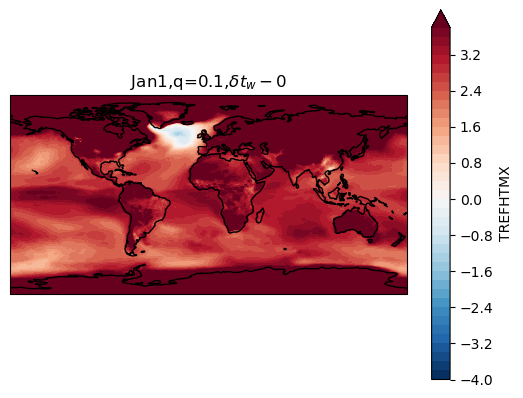

In [45]:
%%time
#Quantile q=0.1
#Plot 3a
levs    = np.arange(-4,4,0.2)
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_djf_diff.sel(quantile=0.1).sel(day=32).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Jan1,q=0.1,'+r'$\delta t_w - 0$')

CPU times: user 3.76 s, sys: 96.2 ms, total: 3.85 s
Wall time: 4.75 s


Text(0.5, 1.0, 'Feb1, q=0.1,$\\delta t_w - \\delta t_{mc}$')

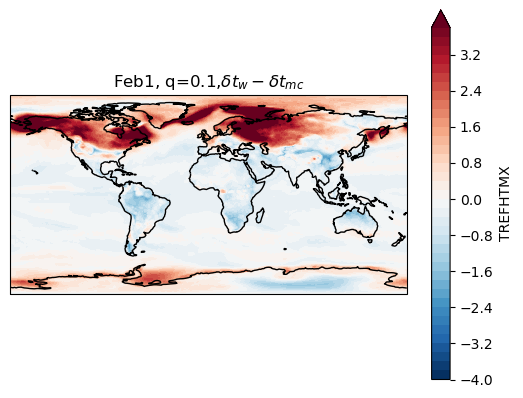

In [49]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_djf_reldiff1.sel(quantile=0.1,day=32).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Feb1, q=0.1,'+r'$\delta t_w - \delta t_{mc}$')

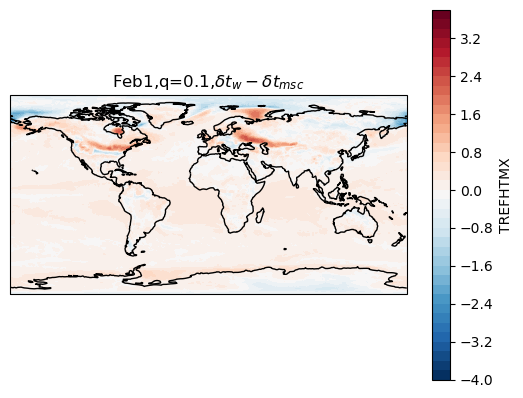

CPU times: user 8.9 s, sys: 156 ms, total: 9.06 s
Wall time: 9.69 s


In [48]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_djf_reldiff2.sel(quantile=0.1,day=32).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('Feb1,q=0.1,'+r'$\delta t_w - \delta t_{msc}$')
plt.show()

In [ ]:
############# Compute area-weighted mean square of the above errors #####################

In [50]:
qgmw_djf_esq  = qgmw_djf_diff**2
qgmc_djf_esq  = qgmw_djf_reldiff1**2
qgmsc_djf_esq = qgmw_djf_reldiff2**2

In [51]:
weights      = np.cos(np.deg2rad(qgmw_djf_esq.lat))
weights.name = "weights"

In [52]:
qgmw_djfserror_weighted  = qgmw_djf_esq.weighted(weights)
qgmc_djfserror_weighted  = qgmc_djf_esq.weighted(weights)
qgmsc_djfserror_weighted = qgmsc_djf_esq.weighted(weights)
qgmc_djf_esq

,Array,Chunk
Bytes,3.74 GiB,2.31 MiB
Shape,"(101, 192, 288, 90)","(101, 20, 30, 5)"
Count,18002 Tasks,1800 Chunks
Type,float64,numpy.ndarray


In [53]:
qgmw_djfserror_gmean   = qgmw_djfserror_weighted.mean({'lat','lon'})
qgmc_djfserror_gmean   = qgmc_djfserror_weighted.mean({'lat','lon'})
qgmsc_djfserror_gmean  = qgmsc_djfserror_weighted.mean({'lat','lon'})
qgmc_djfserror_gmean

<xarray.DataArray 'TREFHTMX' (quantile: 101, day: 90)>
dask.array<truediv, shape=(101, 90), dtype=float64, chunksize=(101, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [54]:
qgmw_djf_gmse   = qgmw_djfserror_gmean.mean({'day'})
qgmc_djf_gmse   = qgmc_djfserror_gmean.mean({'day'})
qgmsc_djf_gmse  = qgmsc_djfserror_gmean.mean({'day'})
qgmc_djf_gmse

<xarray.DataArray 'TREFHTMX' (quantile: 101)>
dask.array<mean_agg-aggregate, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [55]:
%%time
qgmw_djf_grmse         = np.sqrt(qgmw_djf_gmse)
qgmc_djf_grmse         = np.sqrt(qgmc_djf_gmse)
qgmsc_djf_grmse        = np.sqrt(qgmsc_djf_gmse)

CPU times: user 2.35 ms, sys: 13 µs, total: 2.36 ms
Wall time: 2.37 ms


In [59]:
%%time
qgmw_djf_grmsepath  = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_djf_grmsepath  = cvals+'qgmc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_djf_grmsepath = cvals+'qgmsc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
qgmw_djf_grmse.to_dataset().to_zarr(qgmw_djf_grmsepath)
qgmc_djf_grmse.to_dataset().to_zarr(qgmc_djf_grmsepath)
qgmsc_djf_grmse.to_dataset().to_zarr(qgmsc_djf_grmsepath)

CPU times: user 56.9 s, sys: 2.14 s, total: 59 s
Wall time: 1min 17s


In [63]:
%%time
qgmw_djf_grmse  = xr.open_zarr(qgmw_djf_grmsepath)
qgmc_djf_grmse  = xr.open_zarr(qgmc_djf_grmsepath)
qgmsc_djf_grmse = xr.open_zarr(qgmsc_djf_grmsepath)
qgmw_djf_grmse  = qgmw_djf_grmse.TREFHTMX
qgmc_djf_grmse  = qgmc_djf_grmse.TREFHTMX
qgmsc_djf_grmse  = qgmsc_djf_grmse.TREFHTMX

CPU times: user 10.4 ms, sys: 3.13 ms, total: 13.5 ms
Wall time: 14.3 ms


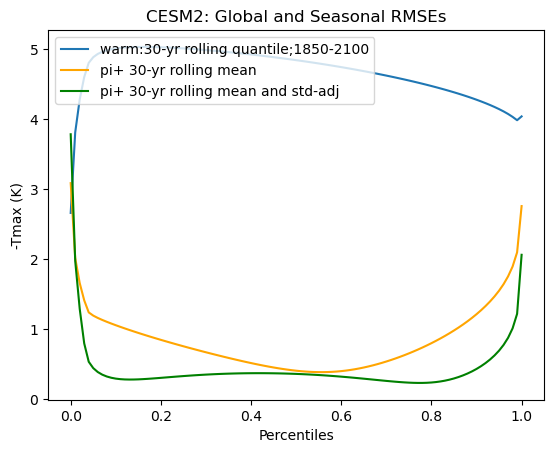

CPU times: user 234 ms, sys: 18.3 ms, total: 253 ms
Wall time: 324 ms


In [65]:
%%time
plt.plot(quants,qgmw_djf_grmse,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,qgmc_djf_grmse,label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,qgmsc_djf_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global and Seasonal RMSEs')
plt.ylabel('-Tmax (K)')
plt.xlabel('Percentiles')
plt.show()